In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [2]:
# 加载训练数据
train_df = pd.read_csv('train.csv')

# 查看前5行数据
print(train_df.head())

# 查看数据基本信息
print("\n数据基本信息:")
print(train_df.info())


   id        X01         Y01        Z01        X11         Y11        Z11  \
0   1  70.462113   64.877114 -50.105813  82.783836   36.042442 -50.988919   
1   2  80.177467  133.621433 -25.956572  75.231644   82.430097 -28.312803   
2   3  94.375668   25.117151 -90.062926  58.594457   90.858450 -35.231873   
3   4  54.436127   85.347174  24.615378   3.513213  139.637270  34.114724   
4   5  90.675942   64.739737 -56.472013  59.220964  140.970317 -23.333981   

         X21         Y21        Z21          X31          Y31           Z31  \
0  33.129188   84.912840 -31.771170  11.74449894  87.84606776  -25.83095954   
1  85.638509    1.648577 -86.316682   4.41007393  91.60476078  -9.267397241   
2  52.880235  134.362373 -40.889689  79.81444417  20.53839623  -84.86809816   
3  43.561212   44.735279 -52.898213    66.481943  133.8555292   23.79353568   
4  -7.020105   96.997434  -1.700752  28.13071821  102.3391386   9.255898442   

            X41           Y41           Z41          X51      

In [3]:
# 检查缺失值(标记为'?')
print("\n缺失值检查:")
# 先检查有多少单元格包含'?'
missing_values = (train_df == '?').sum()
print(missing_values)

# 将'?'替换为NaN以便后续处理
train_df.replace('?', np.nan, inplace=True)

# 现在用常规方法检查NaN
print("\nNaN值统计:")
print(train_df.isnull().sum())


缺失值检查:
id          0
X01         0
Y01         0
Z01         0
X11         0
Y11         0
Z11         0
X21         0
Y21         0
Z21         0
X31       355
Y31       355
Z31       355
X41      1604
Y41      1604
Z41      1604
X51      6634
Y51      6634
Z51      6634
label       0
dtype: int64

NaN值统计:
id          0
X01         0
Y01         0
Z01         0
X11         0
Y11         0
Z11         0
X21         0
Y21         0
Z21         0
X31       355
Y31       355
Z31       355
X41      1604
Y41      1604
Z41      1604
X51      6634
Y51      6634
Z51      6634
label       0
dtype: int64



标签分布:
label
1    8428
3    8343
5    7983
4    7639
2    7607
Name: count, dtype: int64


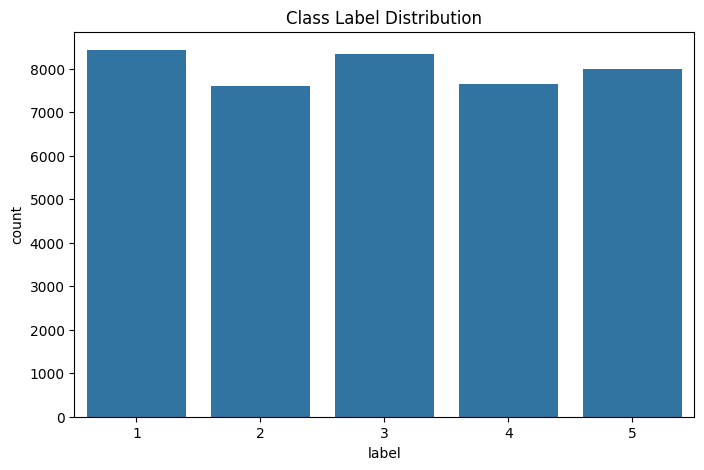

In [4]:
# 查看标签分布
print("\n标签分布:")
label_dist = train_df['label'].value_counts()
print(label_dist)

# 可视化标签分布
plt.figure(figsize=(8,5))
sns.countplot(x='label', data=train_df)
plt.title('Class Label Distribution')
plt.show()


特征数据类型:
X01    float64
Y01    float64
Z01    float64
X11    float64
Y11    float64
Z11    float64
X21    float64
Y21    float64
Z21    float64
X31     object
Y31     object
Z31     object
X41     object
Y41     object
Z41     object
X51     object
Y51     object
Z51     object
dtype: object


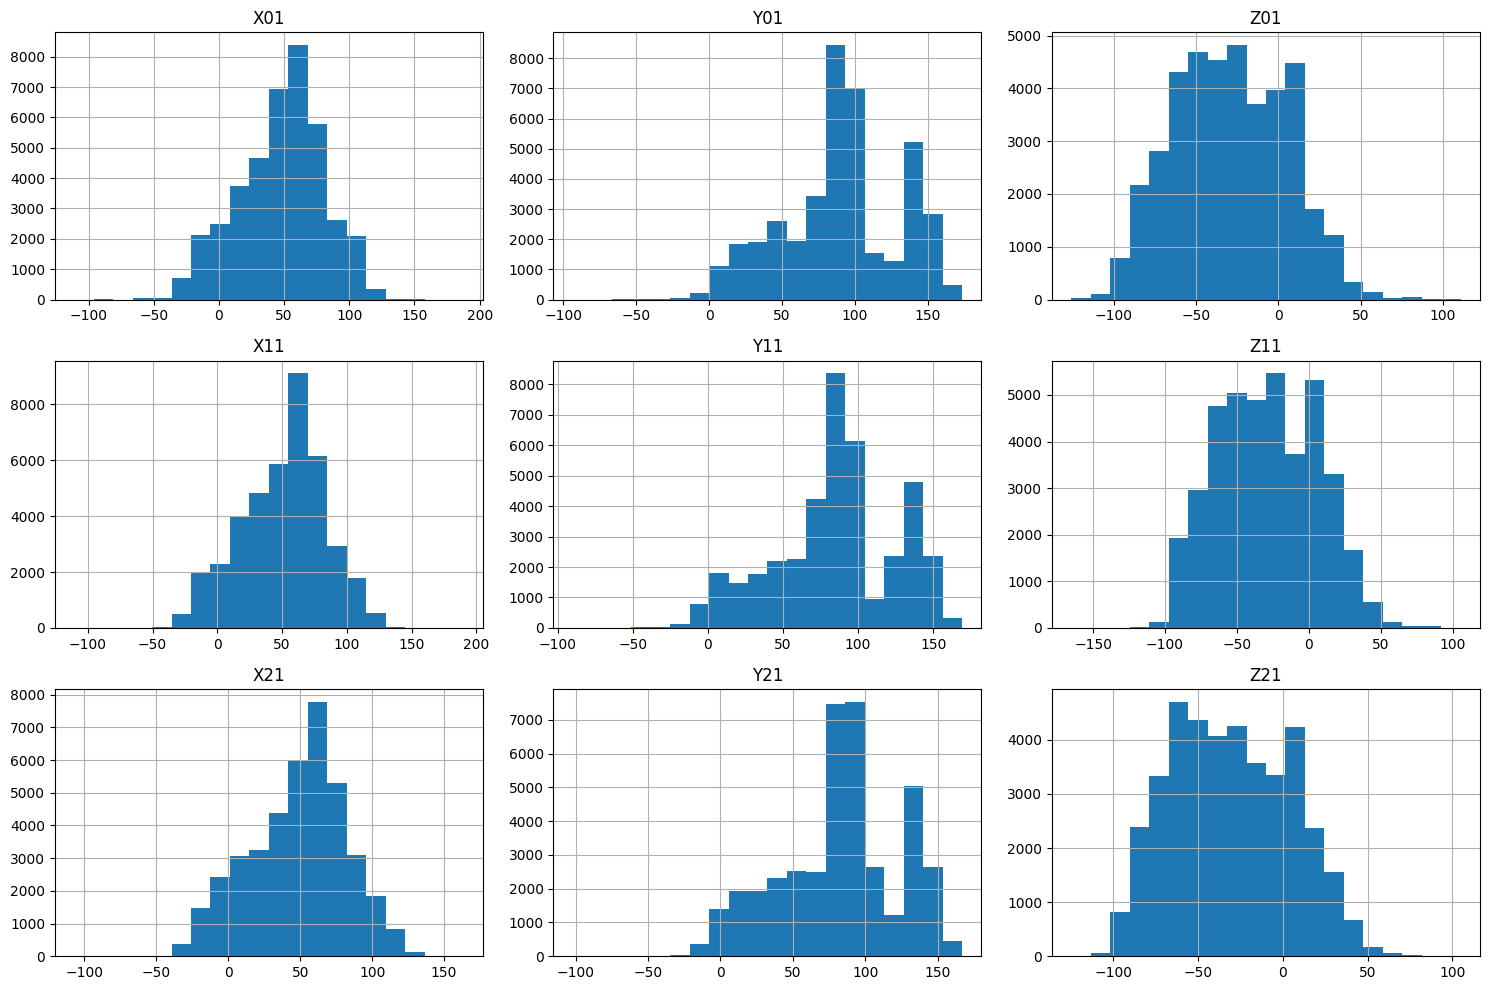

In [5]:
# 分离特征和标签
features = train_df.drop(columns=['label', 'id'])  # 假设id列名为'id'
labels = train_df['label']

# 查看特征类型
print("\n特征数据类型:")
print(features.dtypes)

# 对于数值型特征，绘制分布图
numeric_features = features.select_dtypes(include=['int64', 'float64']).columns
if len(numeric_features) > 0:
    features[numeric_features].hist(bins=20, figsize=(15,10))
    plt.tight_layout()
    plt.show()

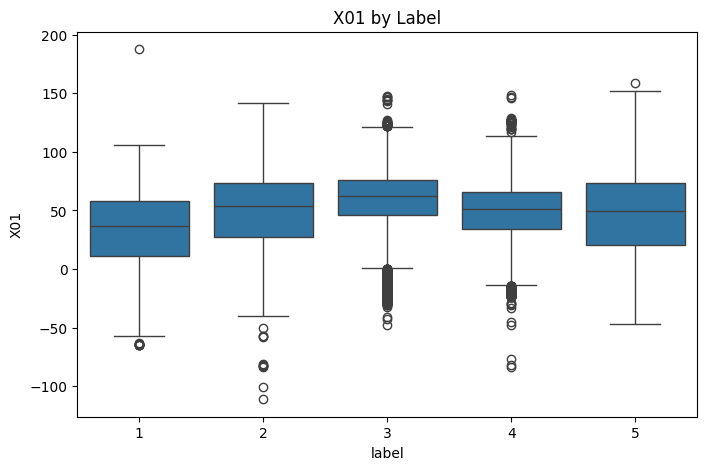

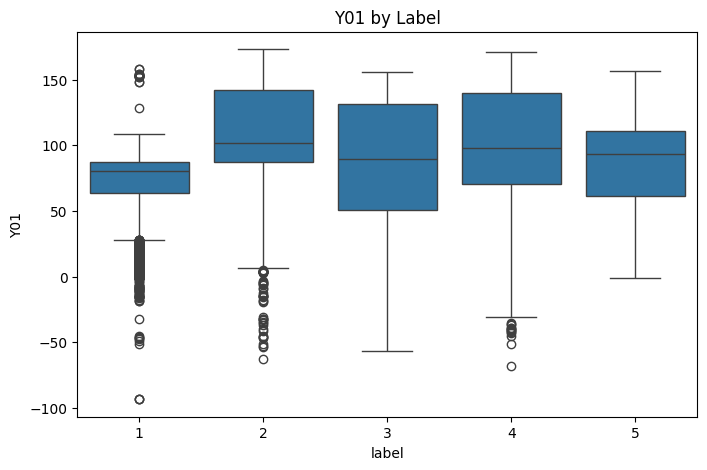

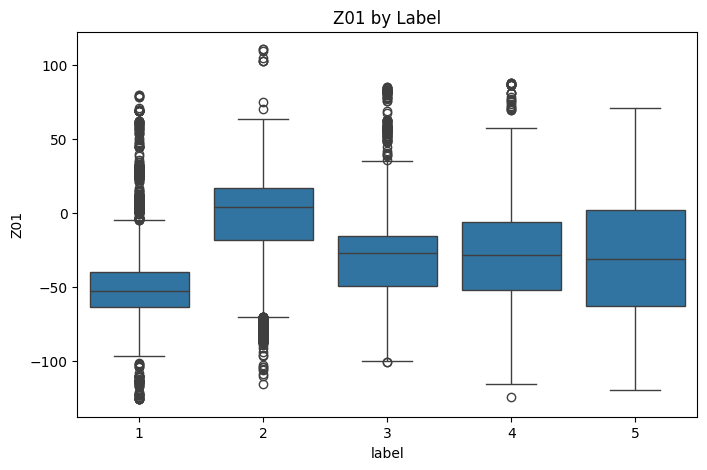

In [6]:
# 选择几个特征查看与标签的关系
if len(numeric_features) >= 3:
    sample_features = numeric_features[:3]  # 只看前三个特征为例
    for feature in sample_features:
        plt.figure(figsize=(8,5))
        sns.boxplot(x='label', y=feature, data=train_df)
        plt.title(f'{feature} by Label')
        plt.show()

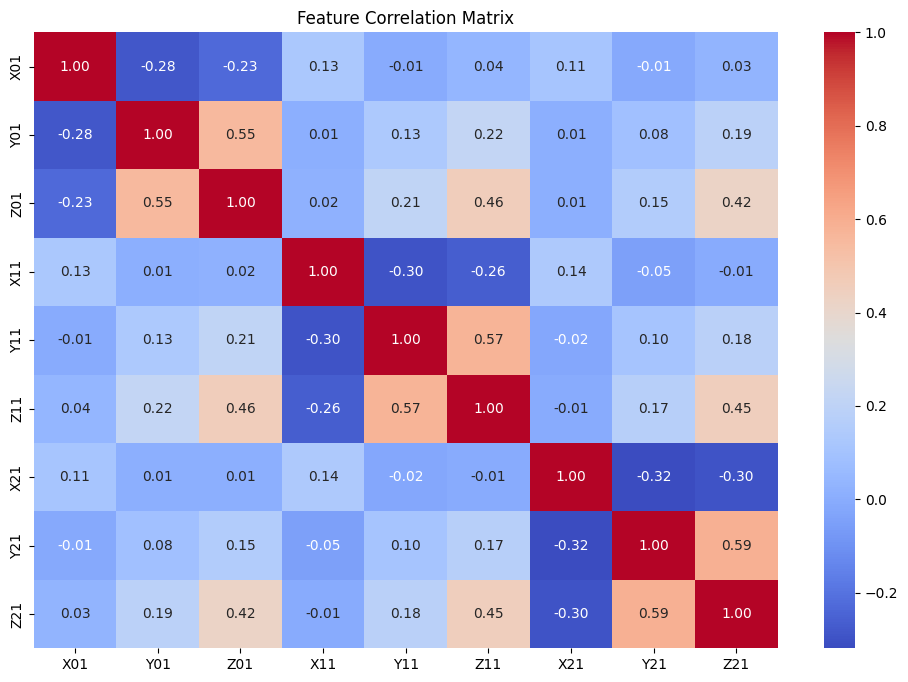

In [7]:
# 计算特征间的相关性(只针对数值特征)
if len(numeric_features) > 1:
    corr_matrix = features[numeric_features].corr()
    plt.figure(figsize=(12,8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Feature Correlation Matrix')
    plt.show()



## Data Processing

### (1) 少量缺失特征（X31/Y31/Z31 - 各355个）

In [8]:
# 转换为数值型并填充中位数（对异常值更鲁棒）
for col in ['X31','Y31','Z31']:
    train_df[col] = pd.to_numeric(train_df[col], errors='coerce')
    train_df[col] = train_df[col].fillna(train_df[col].median())

In [9]:
# 使用KNN填充（考虑特征间关系）
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
cols = ['X41','Y41','Z41']
train_df[cols] = imputer.fit_transform(train_df[cols])

### (2) 中等缺失特征（X41/Y41/Z41 - 各1,604个）

In [10]:
# 使用KNN填充（考虑特征间关系）
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
cols = ['X41','Y41','Z41']
train_df[cols] = imputer.fit_transform(train_df[cols])

### (3) 高缺失特征（X51/Y51/Z51 - 各6,634个）

In [11]:
# 创建缺失标志后删除列（避免噪声）
for col in ['X51','Y51','Z51']:
    train_df[f'{col}_missing'] = train_df[col].isnull().astype(int)
train_df.drop(['X51','Y51','Z51'], axis=1, inplace=True)

In [12]:
# Convert all objects to float.
object_cols = train_df.select_dtypes(include='object').columns
train_df[object_cols] = train_df[object_cols].apply(pd.to_numeric, errors='coerce')

### (4) 异常值处理

In [13]:
# 异常值缩尾处理
from scipy.stats.mstats import winsorize

numeric_cols = train_df.select_dtypes(include=['float64']).columns
for col in numeric_cols:
    train_df[col] = winsorize(train_df[col], limits=[0.05, 0.05])

### (5)特征工程

In [14]:
# 创建向量模长特征
coord_pairs = [('01','X01','Y01','Z01'), 
               ('11','X11','Y11','Z11'),
               ('21','X21','Y21','Z21')]

for suffix, x, y, z in coord_pairs:
    train_df[f'magnitude_{suffix}'] = np.sqrt(
        train_df[x]**2 + train_df[y]**2 + train_df[z]**2)

# 创建统计特征
# 每组(X,Y,Z)的均值/标准差
for suffix in ['01','11','21']:
    cols = [f'X{suffix}', f'Y{suffix}', f'Z{suffix}']
    train_df[f'mean_{suffix}'] = train_df[cols].mean(axis=1)
    train_df[f'std_{suffix}'] = train_df[cols].std(axis=1)

### (6) 特征缩放

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_to_scale = [col for col in train_df.columns 
                    if col not in ['id', 'label'] and 'missing' not in col]
train_df[features_to_scale] = scaler.fit_transform(train_df[features_to_scale])

### (7) 分类标签处理

In [16]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df['label'])

### (8) 数据拆分

In [17]:
# 分离特征和标签
X = train_df.drop(['id', 'label'], axis=1)
y = train_df['label']

# 训练集/验证集划分
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

0
                X01           Y01           Z01           X11           Y11  \
count  32000.000000  32000.000000  32000.000000  32000.000000  32000.000000   
mean       0.000321     -0.000811     -0.000469     -0.003194      0.002664   
std        1.001050      0.999645      0.999721      1.000231      1.000070   
min       -1.964509     -1.923448     -1.705883     -1.952067     -1.971051   
25%       -0.680465     -0.582337     -0.804097     -0.678157     -0.561876   
50%        0.135178      0.011103     -0.020093      0.147936      0.027525   
75%        0.713366      0.688175      0.883513      0.719697      0.757319   
max        1.714915      1.595428      1.729751      1.716502      1.563411   

                Z11           X21           Y21           Z21           X31  \
count  32000.000000  32000.000000  32000.000000  32000.000000  32000.000000   
mean       0.004234      0.000788     -0.002665     -0.001081     -0.002038   
std        1.000279      1.000358      1.000323  

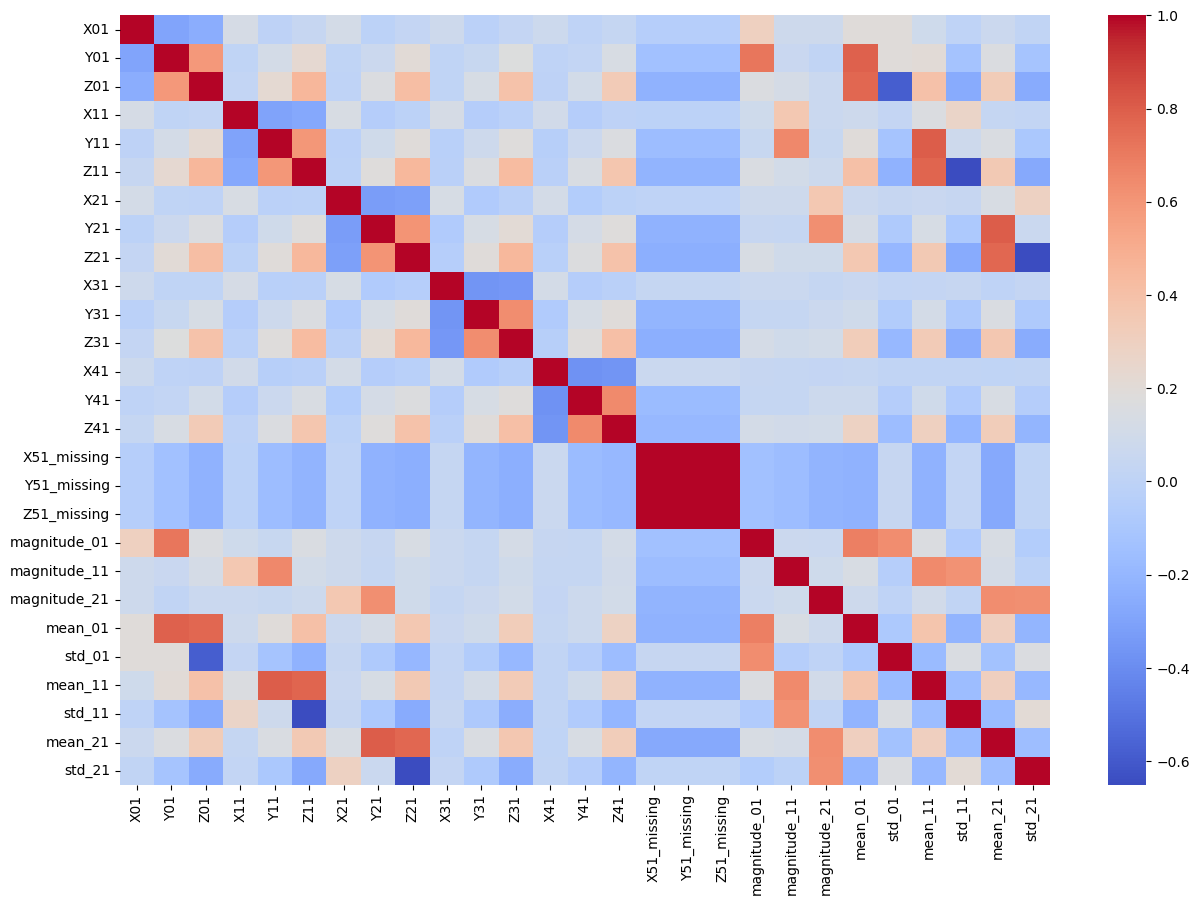

In [18]:
# 检查预处理后数据
print(X_train.isnull().sum().sum())  # 应输出0
print(X_train.describe())  # 查看缩放后分布

# 可视化特征相关性
plt.figure(figsize=(15,10))
sns.heatmap(X_train.corr(), cmap='coolwarm')
plt.show()

# df_sklearn_encoded.to_csv('train_new.csv', index=False)


# ML and GridSearch

### Decision Tree

In [2]:
from randomForest import DecisionTree
from sklearn.metrics import classification_report

# Model Initialization
models = {
    "PyTorch Decision Tree": DecisionTree(max_depth=1, criterion="gini"),
    # "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)  # 可选对比
}

# 快速评估
for name, model in models.items():
    print(f"Training {name}...")  # 修正：仅打印模型名称
    model.fit(X_train, y_train)   # 注意：应使用 X_train 而非 X
    y_pred = model.predict(X_val)
    print(f"\n{name} Performance:")
    print(classification_report(y_val, y_pred.numpy()))  # 注意 .numpy() 转换

Training PyTorch Decision Tree...


NameError: name 'X' is not defined

In [19]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# 初始化模型
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(objective='multi:softmax', num_class=5, random_state=42)
}

# 快速评估
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print(f"\n{name} Performance:")
    print(classification_report(y_val, y_pred))


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1686
           1       0.96      0.96      0.96      1521
           2       0.97      0.97      0.97      1668
           3       0.97      0.95      0.96      1528
           4       0.96      0.98      0.97      1597

    accuracy                           0.97      8000
   macro avg       0.97      0.97      0.97      8000
weighted avg       0.97      0.97      0.97      8000


XGBoost Performance:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1686
           1       0.98      0.99      0.98      1521
           2       0.98      0.99      0.98      1668
           3       0.98      0.98      0.98      1528
           4       0.99      0.99      0.99      1597

    accuracy                           0.99      8000
   macro avg       0.99      0.99      0.99      8000
weighted avg       0.99    

### XGBoost

In [20]:
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, make_scorer, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE  
from imblearn.pipeline import Pipeline  
from scipy.stats import loguniform, randint, uniform
from joblib import load, dump
import os

In [33]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# # 初始化模型（修复objective参数名）
# xgb_model = XGBClassifier(
#     objective='multi:softmax',  # 多分类任务
#     num_class=5,                # 类别数
#     n_estimators=100,
#     random_state=42
# )

# # 训练与评估
# xgb_model.fit(X_train, y_train)
# y_pred = xgb_model.predict(X_val)
# print(classification_report(y_val, y_pred))

# # 超参数优化 (GridSearch)
# param_grid = {
#     'learning_rate': [0.01, 0.1],
#     'max_depth': [3, 5],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }

# from sklearn.model_selection import GridSearchCV
# grid = GridSearchCV(xgb_model, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
# grid.fit(X_train, y_train)
# print("Best params:", grid.best_params_)

xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=5,
    n_estimators=100,
    random_state=42
)

# Baseline
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_val)
print("==== Baseline XGBoost ====")
print(classification_report(y_val, y_pred))

# 网格搜索
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
grid = GridSearchCV(xgb_model, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
grid.fit(X_train, y_train)

print("==== GridSearch Best Params (XGB) ====")
print(grid.best_params_)

xgb_best = grid.best_estimator_
y_pred_best = xgb_best.predict(X_val)
print("==== XGB Best Model on val ====")
print(classification_report(y_val, y_pred_best))

# 保存最佳模型
dump(xgb_best, "saved_models/XGBoost.joblib")
print("XGBoost最佳模型已保存: saved_models/XGBoost.joblib")


==== Baseline XGBoost ====
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1686
           1       0.98      0.99      0.98      1521
           2       0.98      0.99      0.98      1668
           3       0.98      0.98      0.98      1528
           4       0.99      0.99      0.99      1597

    accuracy                           0.99      8000
   macro avg       0.99      0.99      0.99      8000
weighted avg       0.99      0.99      0.99      8000



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


==== GridSearch Best Params (XGB) ====
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 0.8}
==== XGB Best Model on val ====
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1686
           1       0.95      0.94      0.94      1521
           2       0.94      0.96      0.95      1668
           3       0.94      0.93      0.94      1528
           4       0.97      0.95      0.96      1597

    accuracy                           0.95      8000
   macro avg       0.95      0.95      0.95      8000
weighted avg       0.95      0.95      0.95      8000

XGBoost最佳模型已保存: saved_models/XGBoost.joblib


### Random Forest

In [31]:
# from sklearn.ensemble import RandomForestClassifier

# rf_model = RandomForestClassifier(
#     n_estimators=200,
#     class_weight='balanced',  # 处理类别不平衡
#     random_state=42
# )

# rf_model.fit(X_train, y_train)
# y_pred = rf_model.predict(X_val)
# print(classification_report(y_val, y_pred))

# # 特征重要性可视化
# import matplotlib.pyplot as plt
# plt.barh(X_train.columns, rf_model.feature_importances_)
# plt.title("Random Forest Feature Importance")
# plt.show()

# # 超参数优化
# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5]
# }
# grid = GridSearchCV(rf_model, param_grid, cv=3, scoring='f1_macro')
# grid.fit(X_train, y_train)
from sklearn.ensemble import RandomForestClassifier

# 假设你已有 X_train, y_train, X_val, y_val
rf_model = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',  # 用于不平衡数据
    random_state=42
)

# 先直接fit，观察baseline
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_val)
print("==== Baseline RF ====")
print(classification_report(y_val, y_pred))

# 网格搜索
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
grid = GridSearchCV(rf_model, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
grid.fit(X_train, y_train)

# 输出最佳参数
print("==== GridSearch Best Params (RF) ====")
print(grid.best_params_)

# 在验证集上看效果
rf_best = grid.best_estimator_
y_pred_best = rf_best.predict(X_val)
print("==== RF Best Model on val ====")
print(classification_report(y_val, y_pred_best))

# 保存最佳模型
dump(rf_best, "saved_models/Random_Forest.joblib")
print("RF最佳模型已保存: saved_models/Random_Forest.joblib")


==== Baseline RF ====
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1686
           1       0.95      0.96      0.96      1521
           2       0.97      0.97      0.97      1668
           3       0.97      0.96      0.97      1528
           4       0.97      0.98      0.97      1597

    accuracy                           0.97      8000
   macro avg       0.97      0.97      0.97      8000
weighted avg       0.97      0.97      0.97      8000

==== GridSearch Best Params (RF) ====
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
==== RF Best Model on val ====
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1686
           1       0.95      0.96      0.96      1521
           2       0.97      0.97      0.97      1668
           3       0.97      0.96      0.97      1528
           4       0.97      0.98      0.97      1597

    accuracy                 

### Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# 逻辑回归需要数据缩放
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

lr_model = LogisticRegression(
    multi_class='multinomial',  # 多分类
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

lr_model.fit(X_train_scaled, y_train)
y_pred = lr_model.predict(X_val_scaled)
print(classification_report(y_val, y_pred))

# 超参数优化
param_grid = {
    'C': [0.1, 1, 10],        # 正则化强度
    'penalty': ['l2']          # 多分类任务通常用l2
}
grid = GridSearchCV(lr_model, param_grid, cv=3, scoring='f1_macro')
grid.fit(X_train_scaled, y_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.85      0.92      0.88      1686
           1       0.68      0.72      0.70      1521
           2       0.70      0.72      0.71      1668
           3       0.52      0.43      0.47      1528
           4       0.57      0.58      0.57      1597

    accuracy                           0.68      8000
   macro avg       0.67      0.67      0.67      8000
weighted avg       0.67      0.68      0.67      8000



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Pytho

GridSearchCV(cv=3,
             estimator=LogisticRegression(max_iter=1000,
                                          multi_class='multinomial',
                                          random_state=42),
             param_grid={'C': [0.1, 1, 10], 'penalty': ['l2']},
             scoring='f1_macro')

### SVM

In [32]:
# from sklearn.svm import SVC

# svm_model = SVC(
#     kernel='rbf',              
#     class_weight='balanced',   
#     probability=True,        
#     random_state=42
# )

# svm_model.fit(X_train_scaled, y_train)
# y_pred = svm_model.predict(X_val_scaled)
# print(classification_report(y_val, y_pred))

# # 超参数优化
# param_grid = {
#     'C': [0.1, 1, 10],
#     'gamma': ['scale', 'auto']
# }
# grid = GridSearchCV(svm_model, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
# grid.fit(X_train_scaled, y_train)
from sklearn.svm import SVC

# 示例：如果需要标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

svm_model = SVC(
    kernel='rbf',
    class_weight='balanced',
    probability=True,  # 需要概率输出就加上
    random_state=42
)

# Baseline
svm_model.fit(X_train_scaled, y_train)
y_pred = svm_model.predict(X_val_scaled)
print("==== Baseline SVM ====")
print(classification_report(y_val, y_pred))

# 网格搜索
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}
grid = GridSearchCV(svm_model, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
grid.fit(X_train_scaled, y_train)

print("==== GridSearch Best Params (SVM) ====")
print(grid.best_params_)

svm_best = grid.best_estimator_
y_pred_best = svm_best.predict(X_val_scaled)
print("==== SVM Best Model on val ====")
print(classification_report(y_val, y_pred_best))

# 保存最佳模型
dump(svm_best, "saved_models/SVM.joblib")
print("SVM最佳模型已保存: saved_models/SVM.joblib")

# **同时** 也要保存好训练所用到的Scaler (如果你需要在预测时对test做同样transform)
dump(scaler, "saved_models/SVM_Scaler.joblib")
print("SVM所用的Scaler已保存: saved_models/SVM_Scaler.joblib")


==== Baseline SVM ====
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1686
           1       0.86      0.86      0.86      1521
           2       0.86      0.95      0.90      1668
           3       0.86      0.82      0.84      1528
           4       0.96      0.89      0.92      1597

    accuracy                           0.90      8000
   macro avg       0.90      0.90      0.90      8000
weighted avg       0.90      0.90      0.90      8000

==== GridSearch Best Params (SVM) ====
{'C': 10, 'gamma': 'scale'}
==== SVM Best Model on val ====
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1686
           1       0.92      0.91      0.91      1521
           2       0.91      0.96      0.93      1668
           3       0.90      0.89      0.89      1528
           4       0.96      0.94      0.95      1597

    accuracy                           0.94      8000
   macro 

In [34]:
from sklearn.metrics import f1_score

models = {
    "XGBoost": xgb_model,
    "Random Forest": rf_model,
    "Logistic Regression": lr_model,
    "SVM": svm_model
}

for name, model in models.items():
    if "Logistic" in name or "SVM" in name:
        y_pred = model.predict(X_val_scaled)  # 注意缩放数据
    else:
        y_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_pred, average='macro')
    print(f"{name} Macro-F1: {f1:.4f}")

XGBoost Macro-F1: 0.9857
Random Forest Macro-F1: 0.9715
Logistic Regression Macro-F1: 0.6676
SVM Macro-F1: 0.9007


## Test Dataset Prediction and Result Saving

KeyError: 'ExtracurricularActivities'